To be run after 'intensity_profile_radii_frank_fit.ipynb' and 'intensity_profile_CLEAN.ipynb'

In [2]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

import frank
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.utilities import convolve_profile, sweep_profile
from frank.io import save_fit, load_sol
from frank.make_figs import make_full_fig
from gofish import imagecube  # for the CLEAN profile
sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err

from scipy.integrate import simpson
from scipy import signal
from scipy.interpolate import interp1d
import pandas as pd

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [3]:
target = 'AA_Tau'
target_label = disk.disk[target]['label']

robust = -0.5

In [4]:
frank_fit = np.loadtxt(f'{target}_frank_profile.txt')
r_frank_arcsec = frank_fit[:,0]
r_frank_au = frank_fit[:,1]
I_frank_jy_sr = frank_fit[:,2]
Tb_frank = frank_fit[:,3]

frank_radii = np.loadtxt(f'{target}_continuum_radii_frank_fit.txt')
R90_arcsec = frank_radii[1,1]
R90_au = frank_radii[0,1]

RMS_data_mjy_bm = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[5]
distance_pc = disk.disk[target]['distance']

Four criteria (see Section 4.1 of exoALMA IV paper):
1. Rings and gaps must correspond to local maxima and minima, respectively, of the best-fit frank model intensity radial profile.
2. Their radial location must fall within R_90.
3. Peak intensity of each ring must be higher than the rms noise.
4. We accept a gap-ring pair if it meets the gap depth condition I_D / I_B <= 0.97, where I_D is the intensity of the gap minimum and I_B is the ring peak intensity.

In [6]:
### [Criterion 1]: Identify local maxima and minima 
i_max, _ = signal.find_peaks(I_frank_jy_sr)
i_min, _ = signal.find_peaks(-I_frank_jy_sr)

### [Criterion 2]: Accept only maxima and minima within R90
i_max = i_max[r_frank_arcsec[i_max] < R90_arcsec]
i_min = i_min[r_frank_arcsec[i_min] < R90_arcsec]

### [Criterion 3]: Accept only rings with peak intensity above the RMS

# RMS varying with radius
CLEAN_profile = np.loadtxt(f'{target}_CLEAN_profile_robust{robust}.txt')
r_clean_arcsec = CLEAN_profile[:,0]
r_clean_au = CLEAN_profile[:,1]
I_clean_jy_sr = CLEAN_profile[:,6]
dI_clean_jy_sr = CLEAN_profile[:,7]
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2
RMS_R_data_mjy_bm = RMS_data_mjy_bm / np.sqrt((2*np.pi*r_clean_arcsec)/bmaj)
RMS_R_data_jy_sr = RMS_R_data_mjy_bm * 1e-3 / beam_area
RMS_interp = interp1d(r_clean_arcsec, RMS_R_data_jy_sr)

i_max = i_max[I_frank_jy_sr[i_max] > RMS_interp(r_frank_arcsec[i_max])]

In [7]:
# Final radii of valid candidates after criteria 1, 2, and 3
r_max = r_frank_arcsec[i_max]
r_min = r_frank_arcsec[i_min]
r_all = np.sort(np.concatenate([r_max, r_min]))

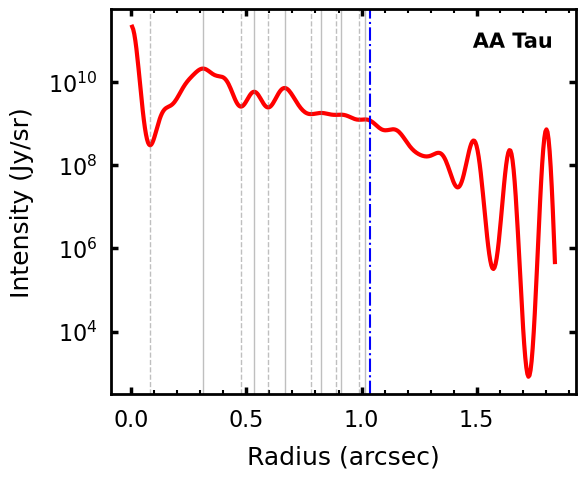

In [8]:
fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank_arcsec, I_frank_jy_sr, color='r', linewidth=3)

for i in range(r_max.size):
    ax.axvline(r_max[i], color='gray', alpha=0.5, linewidth=1)
    
for i in range(r_min.size):
    ax.axvline(r_min[i], color='gray', linestyle='dashed', alpha=0.5, linewidth=1)

ax.axvline((R90_arcsec), linestyle='dashdot', color='blue', linewidth=1.5)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

ax.set_yscale('log')
#ax.set_ylim(1e7,5e11)
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Intensity (Jy/sr)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

In [9]:
### [Criterion 4]: Accept gap ring pairs having a contrast I_D/I_B <= 0.97

# Interpolate the frank profile to evaluate I(r) continuously
I_frank_interp = interp1d(r_frank_arcsec, I_frank_jy_sr)

valid_structures = []

# Check if the first substructure is a GAP
first_is_gap = r_all[0] in r_min
i = 0

if not first_is_gap:
    # First element is a RING -> special handling
    if len(r_all) > 1 and r_all[1] in r_min:
        r_ring = r_all[0]
        r_gap = r_all[1]
        I_B = I_frank_interp(r_ring)
        I_D = I_frank_interp(r_gap)

        # Apply contrast criterion
        if I_B > 0 and I_D / I_B <= 0.97:
            valid_structures.append((r_ring, 'ring'))
            valid_structures.append((r_gap, 'gap'))
            i = 1 
        else:
            # Ring is too shallow -> discard it, start from the gap
            i = 1
    else:
        i = 1  # fallback safety

# From here on, always expect GAP - RING pairs
while i < len(r_all) - 1:
    r_gap = r_all[i]
    r_ring = r_all[i + 1]

    if r_gap in r_min and r_ring in r_max:
        I_D = I_frank_interp(r_gap)
        I_B = I_frank_interp(r_ring)

        # Apply depth criterion
        if I_B > 0 and I_D / I_B <= 0.97:
            valid_structures.append((r_gap, 'gap'))
            valid_structures.append((r_ring, 'ring'))

    i += 2  # move two steps forward each time

# Extract radius values for each type
gaps_arcsec = np.array([r for r, t in valid_structures if t == 'gap'])
rings_arcsec = np.array([r for r, t in valid_structures if t == 'ring'])

gaps_au = gaps_arcsec * distance_pc
rings_au = rings_arcsec * distance_pc

print(f'Radial position of RINGS: {[round(x,3) for x in rings_arcsec]} arcsec = {[round(x,1) for x in rings_au]} au')
print(f'Radial position of GAPS: {[round(x,3) for x in gaps_arcsec]} arcsec = {[round(x,1) for x in gaps_au]} au')

Radial position of RINGS: [0.312, 0.533, 0.666, 0.823] arcsec = [42.0, 71.8, 89.8, 110.9] au
Radial position of GAPS: [0.082, 0.478, 0.593, 0.782] arcsec = [11.0, 64.3, 79.8, 105.3] au


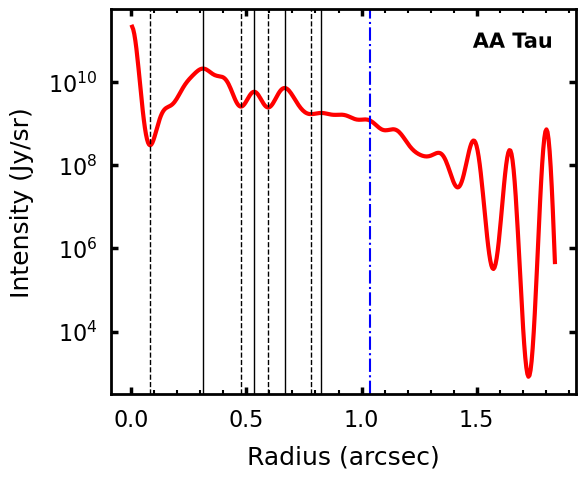

In [10]:
fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank_arcsec, I_frank_jy_sr, color='r', linewidth=3)

for i in range(rings_arcsec.size):
    ax.axvline(rings_arcsec[i], color='k', alpha=1, linewidth=1)
    
for i in range(gaps_arcsec.size):
    ax.axvline(gaps_arcsec[i], color='k', linestyle='dashed', alpha=1, linewidth=1)

ax.axvline((R90_arcsec), linestyle='dashdot', color='blue', linewidth=1.5)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

ax.set_yscale('log')
#ax.set_ylim(1e7,5e11)
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Intensity (Jy/sr)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

# frank + CLEAN profiles

Text(0, 0.5, 'Intensity (Jy sr$^{-1}$)')

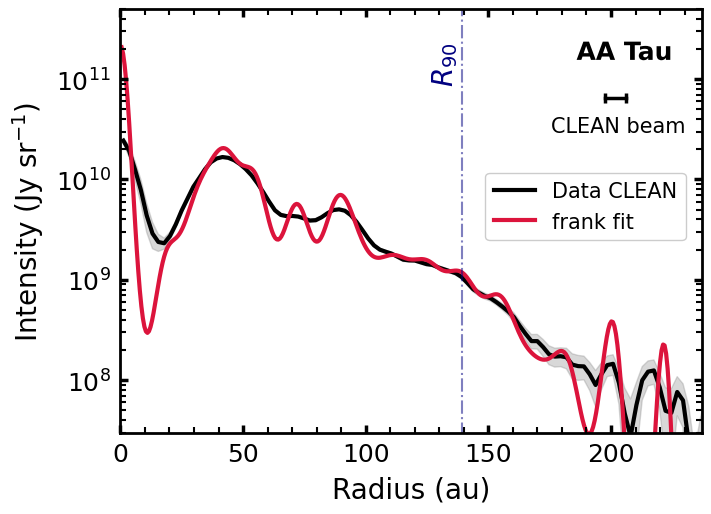

In [12]:
fig = plt.figure(figsize=(7.5,5.5))
ax =fig.add_subplot()

ymax = 5e11   
ymin = 3e7   
xmax = R90_au * 1.7
xindex_ticks = 50


ax.fill_between(r_clean_au, I_clean_jy_sr-dI_clean_jy_sr, I_clean_jy_sr+dI_clean_jy_sr, color='gray', alpha=0.3, zorder=1)
ax.plot(r_clean_au, I_clean_jy_sr, 'k', lw=3, label='Data CLEAN', zorder=1)
ax.plot(r_frank_au, I_frank_jy_sr, 'crimson', lw=3, label='frank fit', zorder=1)

# If the frank fit bootstrap has been run
#frank_error = np.loadtxt(f'../frank_fit/frank_fit_bootstrap/{target}_uncertainty_frank_profile.txt')
#ax.fill_between(r_frank_au, I_frank_jy_sr-frank_error, I_frank_jy_sr+frank_error, color='crimson', alpha=0.15, zorder=1)

# indicate R90
ax.vlines(R90_au, ymin/3, ymax*30, linestyle='dashdot', color='navy', lw=1.5, alpha=0.5)
ax.text(R90_au-13, 1e11,'$R_{90}$', rotation=90, fontsize=20, color='navy')

# indicate beam FWHM
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
mean_beam_au = (bmaj+bmin)/2 * distance_pc
y_pos_beam = 10 ** (np.log10(ymin) + 0.79 * (np.log10(ymax) - np.log10(ymin)))
ax.plot([xmax/1.2, xmax/1.2+mean_beam_au], [y_pos_beam, y_pos_beam], color='k', lw=2.5, marker='|', markersize=7, markeredgewidth=2.5)
ax.text(xmax/1.2-22, 3e10,'CLEAN beam', fontsize=15, color='k')

ax.set_xlim([0, xmax])      

if xindex_ticks == 100 or xindex_ticks == 50 or xindex_ticks == 10:
    minor_xindex_ticks = xindex_ticks/5
elif xindex_ticks == 30:
    minor_xindex_ticks = xindex_ticks/3
elif xindex_ticks == 20:
    minor_xindex_ticks = xindex_ticks/4

ax.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(minor_xindex_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=18, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=18, pad=7,width=1.5, length=4,direction='in',color='k')

ax.legend(fontsize=15, bbox_to_anchor=(0.61, 0.43), framealpha=1)

# Write source name
ax.text(0.95, 0.88, s=target_label,
        transform=ax.transAxes, color='k', fontsize=18, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=4, foreground="w")], ha='right')

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ax.set_ylim([ymin, ymax])         

ax.set_xlabel('Radius (au)', fontsize = 20, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 20, labelpad=7)

With substructure indications

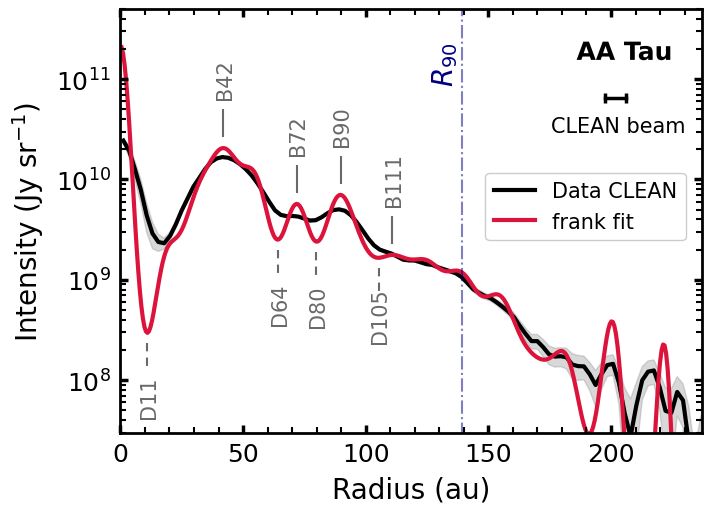

In [14]:
fig = plt.figure(figsize=(7.5,5.5))
ax =fig.add_subplot()

ymax = 5e11   
ymin = 3e7   
xmax = R90_au * 1.7
xindex_ticks = 50


ax.fill_between(r_clean_au, I_clean_jy_sr-dI_clean_jy_sr, I_clean_jy_sr+dI_clean_jy_sr, color='gray', alpha=0.3, zorder=1)
ax.plot(r_clean_au, I_clean_jy_sr, 'k', lw=3, label='Data CLEAN', zorder=1)
ax.plot(r_frank_au, I_frank_jy_sr, 'crimson', lw=3, label='frank fit', zorder=1)

# If the frank fit bootstrap has been run
#frank_error = np.loadtxt(f'../frank_fit/frank_fit_bootstrap/{target}_uncertainty_frank_profile.txt')
#ax.fill_between(r_frank_au, I_frank_jy_sr-frank_error, I_frank_jy_sr+frank_error, color='crimson', alpha=0.15, zorder=1)

# indicate R90
ax.vlines(R90_au, ymin/3, ymax*30, linestyle='dashdot', color='navy', lw=1.5, alpha=0.5)
ax.text(R90_au-13, 1e11,'$R_{90}$', rotation=90, fontsize=20, color='navy')

# indicate beam FWHM
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
mean_beam_au = (bmaj+bmin)/2 * distance_pc
y_pos_beam = 10 ** (np.log10(ymin) + 0.79 * (np.log10(ymax) - np.log10(ymin)))
ax.plot([xmax/1.2, xmax/1.2+mean_beam_au], [y_pos_beam, y_pos_beam], color='k', lw=2.5, marker='|', markersize=7, markeredgewidth=2.5)
ax.text(xmax/1.2-22, 3e10,'CLEAN beam', fontsize=15, color='k')

ax.set_xlim([0, xmax])      

if xindex_ticks == 100 or xindex_ticks == 50 or xindex_ticks == 10:
    minor_xindex_ticks = xindex_ticks/5
elif xindex_ticks == 30:
    minor_xindex_ticks = xindex_ticks/3
elif xindex_ticks == 20:
    minor_xindex_ticks = xindex_ticks/4

ax.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(minor_xindex_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=18, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=18, pad=7,width=1.5, length=4,direction='in',color='k')

ax.legend(fontsize=15, bbox_to_anchor=(0.61, 0.43), framealpha=1)

# Write source name
ax.text(0.95, 0.88, s=target_label,
        transform=ax.transAxes, color='k', fontsize=18, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=4, foreground="w")], ha='right')

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ax.set_ylim([ymin, ymax])         

ax.set_xlabel('Radius (au)', fontsize = 20, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 20, labelpad=7)

################################
##### Substructures #####
################################

##### Substructures #####
len_line = (np.log10(ymax)-np.log10(ymin))/15
dist_line = (np.log10(ymax)-np.log10(ymin))/ 40

int_gaps_au = np.rint(gaps_au).astype(int)
int_rings_au = np.rint(rings_au).astype(int)

# Gaps
if len(gaps_au) == 0:
    pass
else:
    for i in range(gaps_au.shape[0]):
        ypos = 10**(np.log10(I_frank_interp(gaps_arcsec[i]))-dist_line)
        ax.vlines(gaps_au[i], ypos, 10**(np.log10(ypos)-len_line), color='dimgray', linestyle=(0,(4,3)))
        ax.text(gaps_au[i]-xmax/70, 10**(np.log10(ypos)-len_line*2.5), f"D{int_gaps_au[i]}", rotation=90, fontsize=15, color='dimgray')

# Rings
if len(rings_au) == 0:
    pass
else:
    for i in range(rings_au.shape[0]):
        ypos = 10**(np.log10(I_frank_interp(rings_arcsec[i]))+dist_line)
        ax.vlines(rings_au[i], ypos, 10**(np.log10(ypos)+len_line), color='dimgray')
        ax.text(rings_au[i]-xmax/70, 10**(np.log10(ypos)+len_line*1.5), f"B{int_rings_au[i]}", rotation=90, fontsize=15, color='dimgray')

plt.savefig(f'{target}_intensity_profile_CLEAN_frank.pdf', bbox_inches='tight')

# Compute substructure width, depth, R_in and R_out

See section 4.1 of exoALMA IV for the definitions.

In [17]:
# Gaps depth

gaps_depth = []
if first_is_gap:
    i = 0 
    while i < len(valid_structures) - 1:
        gaps_depth.append(I_frank_interp(valid_structures[i][0]) / I_frank_interp(valid_structures[i+1][0]))
        i += 2
else:
    i = 1 
    while i < len(valid_structures) - 1:
        gaps_depth.append(I_frank_interp(valid_structures[i][0]) / I_frank_interp(valid_structures[i+1][0]))
        i += 2

for i in range(len(gaps_depth)):
    print(f'Gaps n.{i} depth = {gaps_depth[i]:.2f}')

Gaps n.0 depth = 0.01
Gaps n.1 depth = 0.44
Gaps n.2 depth = 0.34
Gaps n.3 depth = 0.94


In [18]:
epsilon_precision = 5e-2
r_boundary = {}
gap_width_au = {}
gap_width_arcsec = {}
ring_width_au = {}
ring_width_arcsec = {}

for i in range(gaps_arcsec.size):
     
    ####################    
    ###### rd_out ######
    ####################
    x_arr = np.linspace(gaps_arcsec[i], rings_arcsec[i], 5000)
    y_arr = I_frank_interp(x_arr)

    # Value of y for which you want to find x
    desired_y = np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])])

    # Using a search method to find x corresponding to the desired value of y
    # Approximation search method
    x_at_desired_y = x_arr[0]  # Initial x value
    epsilon = np.amin(y_arr) * epsilon_precision  # Tolerance for approximation

    j = 0
    while abs(I_frank_interp(x_at_desired_y) - desired_y) > epsilon and j < x_arr.size-1:
        j+=1
        x_at_desired_y = x_arr[j]    
        if x_at_desired_y > max(x_arr):
            break  # Stop the search if x exceeds the maximum
    
    print(f'Searching rd{i}_out')
    if x_at_desired_y < max(x_arr):
        #print(f"The value of x corresponding to y={desired_y:.5e} is approximately x={x_at_desired_y:.2f}")
        #print(f"Check:  desired_y = {desired_y:.5e}, while I_frank_interp(x_at_desired_y) = {I_frank_interp(x_at_desired_y):.5e}, and their ratio is {desired_y/I_frank_interp(x_at_desired_y):.3f}")
        r_boundary[f'd{i}_out'] = x_at_desired_y
    else:
        print("Couldn't converge at this level of approximation")
        
    ###################    
    ###### rd_in ######
    ###################
    if i == 0:
        x_arr = np.linspace(r_frank_arcsec[0], gaps_arcsec[i], 5000)
    else:
        x_arr = np.linspace(rings_arcsec[i-1], gaps_arcsec[i], 5000)
    y_arr = I_frank_interp(x_arr)

    # Value of y for which you want to find x
    desired_y = np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])])

    # Using a search method to find x corresponding to the desired value of y
    # Approximation search method
    x_at_desired_y = x_arr[0]  # Initial x value
    epsilon = np.amin(y_arr) * epsilon_precision  # Tolerance for approximation

    j = 0
    while abs(I_frank_interp(x_at_desired_y) - desired_y) > epsilon and j < x_arr.size-1:
        j+=1
        x_at_desired_y = x_arr[j]    
        if x_at_desired_y > max(x_arr):
            break  # Stop the search if x exceeds the maximum
    
    print(f'Searching rd{i}_in')
    if x_at_desired_y < max(x_arr):
        #print(f"The value of x corresponding to y={desired_y:.5e} is approximately x={x_at_desired_y:.2f}")
        #print(f"Check:  desired_y = {desired_y:.5e}, while I_frank_interp(x_at_desired_y) = {I_frank_interp(x_at_desired_y):.5e}, and their ratio is {desired_y/I_frank_interp(x_at_desired_y):.3f}")
        r_boundary[f'd{i}_in'] = x_at_desired_y
    else:
        print("Couldn't converge at this level of approximation")
        
        
    ####################    
    ###### rb_out ######
    ####################
    if i == gaps_arcsec.size - 1:
        x_arr = np.linspace(rings_arcsec[i], R90_arcsec, 5000)
    else:
        x_arr = np.linspace(rings_arcsec[i], gaps_arcsec[i+1], 5000)
    y_arr = I_frank_interp(x_arr)

    # Value of y for which you want to find x
    desired_y = np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])])

    # Using a search method to find x corresponding to the desired value of y
    # Approximation search method
    x_at_desired_y = x_arr[0]  # Initial x value
    epsilon = np.amin(y_arr) * epsilon_precision  # Tolerance for approximation

    j = 0
    while abs(I_frank_interp(x_at_desired_y) - desired_y) > epsilon and j < x_arr.size-1:
        j+=1
        x_at_desired_y = x_arr[j]    
        if x_at_desired_y > max(x_arr):
            break  # Stop the search if x exceeds the maximum
    

    print(f'Searching rb{i}_out')
    if x_at_desired_y < max(x_arr):
        #print(f"The value of x corresponding to y={desired_y:.5e} is approximately x={x_at_desired_y:.2f}")
        #print(f"Check:  desired_y = {desired_y:.5e}, while I_frank_interp(x_at_desired_y) = {I_frank_interp(x_at_desired_y):.5e}, and their ratio is {desired_y/I_frank_interp(x_at_desired_y):.3f}")
        r_boundary[f'b{i}_out'] = x_at_desired_y
    else:
        print("Couldn't converge at this level of approximation")
    

        
    
    gap_width_arcsec[f'Gap{i}'] = r_boundary[f'd{i}_out']-r_boundary[f'd{i}_in']
    gap_width_au[f'Gap{i}'] = gap_width_arcsec[f'Gap{i}'] * distance_pc
    
    print(f"Width of Gap{i} at {gaps_au[i]:.1f} au =  {gap_width_au[f'Gap{i}']:.1f} au  =  {gap_width_arcsec[f'Gap{i}']*1e3:.0f} mas")
    
    ring_width_arcsec[f'Ring{i}'] = r_boundary[f'b{i}_out']-r_boundary[f'd{i}_out']
    ring_width_au[f'Ring{i}'] = ring_width_arcsec[f'Ring{i}'] * distance_pc
    
    print(f"Width of Ring{i} at {rings_au[i]:.1f} au =  {ring_width_au[f'Ring{i}']:.1f} au  =  {ring_width_arcsec[f'Ring{i}']*1e3:.0f} mas")
        
                
    print(' ')

Searching rd0_out
Searching rd0_in
Searching rb0_out
Width of Gap0 at 11.0 au =  28.1 au  =  209 mas
Width of Ring0 at 42.0 au =  22.7 au  =  168 mas
 
Searching rd1_out
Searching rd1_in
Searching rb1_out
Width of Gap1 at 64.3 au =  8.1 au  =  60 mas
Width of Ring1 at 71.8 au =  6.9 au  =  51 mas
 
Searching rd2_out
Searching rd2_in
Searching rb2_out
Width of Gap2 at 79.8 au =  11.1 au  =  83 mas
Width of Ring2 at 89.8 au =  8.7 au  =  65 mas
 
Searching rd3_out
Searching rd3_in
Searching rb3_out
Width of Gap3 at 105.3 au =  3.2 au  =  24 mas
Width of Ring3 at 110.9 au =  5.6 au  =  41 mas
 


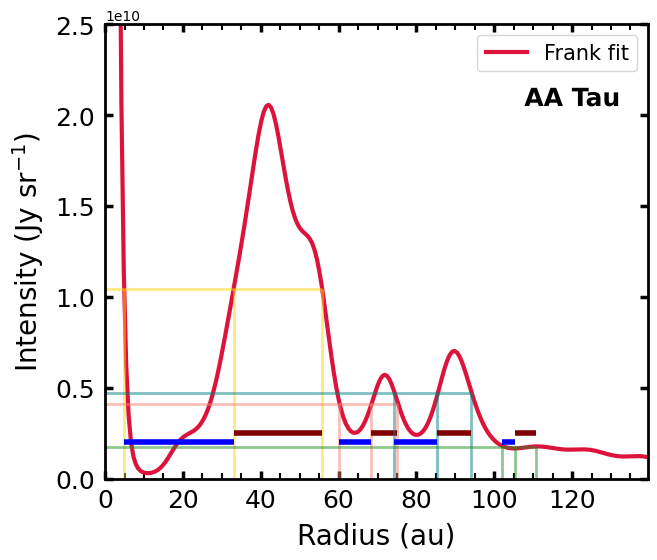

In [19]:
#############################
### Plot the radial profile
#############################


fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.plot(r_frank_au, I_frank_jy_sr, 'crimson', lw=3, label='Frank fit')


ax.set_xlim([0, R90_au])
xindex_ticks = 20
ax.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(xindex_ticks/4))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=18, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=18, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (au)', fontsize = 20, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 20, labelpad=7)
ax.legend(fontsize=15)

# Write source name
ax.text(0.95, 0.82, s=target_label,
        transform=ax.transAxes, color='k', fontsize=18, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")], ha='right')

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

#ax.set_yscale('log')
ymin=0
ymax=2.5e10
ax.set_ylim([ymin, ymax]) 

colors=['gold', 'salmon', 'teal', 'forestgreen', ]
for i in range(gaps_au.size):
    ax.vlines(r_boundary[f'd{i}_in']*distance_pc, 0, np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])]), linestyle='solid', lw=2, color=colors[i], alpha=0.5)
    ax.vlines(r_boundary[f'd{i}_out']*distance_pc, 0, np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])]), linestyle='solid', lw=2, color=colors[i], alpha=0.5)
    ax.vlines(r_boundary[f'b{i}_out']*distance_pc, 0, np.mean([I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])]), linestyle='solid', lw=2, color=colors[i], alpha=0.5)
    ax.hlines(np.mean([[I_frank_interp(gaps_arcsec[i]), I_frank_interp(rings_arcsec[i])]]), 0, r_boundary[f'b{i}_out']*distance_pc, linestyle='solid', lw=2, color=colors[i], alpha=0.5)
    ax.hlines(0.2e10, r_boundary[f'd{i}_in']*distance_pc, r_boundary[f'd{i}_in']*distance_pc+gap_width_au[f'Gap{i}'], linestyle='solid', lw=4, color='blue')
    ax.hlines(0.25e10, r_boundary[f'd{i}_out']*distance_pc, r_boundary[f'd{i}_out']*distance_pc+ring_width_au[f'Ring{i}'], linestyle='solid', lw=4, color='maroon')

In [20]:
# Output data list
rows = []

for i, (r_arcsec, typ) in enumerate(valid_structures):
    is_ring = int(typ == 'ring')
    width_arcsec = ring_width_arcsec.get(f'Ring{i//2}', np.nan) if is_ring else gap_width_arcsec.get(f'Gap{i//2}', np.nan)
    width_au = width_arcsec * distance_pc if not np.isnan(width_arcsec) else np.nan
    gap_depth = np.nan if is_ring else gaps_depth[i//2]

    if is_ring:
        r_in_arcsec = r_boundary.get(f'd{i//2}_out', np.nan)
        r_out_arcsec = r_boundary.get(f'b{i//2}_out', np.nan)
    else:
        r_in_arcsec = r_boundary.get(f'd{i//2}_in', np.nan)
        r_out_arcsec = r_boundary.get(f'd{i//2}_out', np.nan)

    r_in_au = r_in_arcsec * distance_pc if not np.isnan(r_in_arcsec) else np.nan
    r_out_au = r_out_arcsec * distance_pc if not np.isnan(r_out_arcsec) else np.nan

    rows.append([
        round(r_arcsec * distance_pc, 1),
        round(r_arcsec, 3),
        is_ring,
        round(width_au, 1),
        round(width_arcsec, 3),
        round(gap_depth, 2) if not np.isnan(gap_depth) else 'nan',
        round(r_in_au, 1),
        round(r_in_arcsec, 3),
        round(r_out_au, 1),
        round(r_out_arcsec, 3)
    ])

# Create DataFrame and save
columns = ['Radial_location(au)', 'Radial_location(arcsec)', 'Flag(0 for gaps, 1 for rings)',
           'Width(au)', 'Width(arcsec)', 'Gap_depth', 'R_in(au)', 'R_in(arcsec)', 'R_out(au)', 'R_out(arcsec)']
df = pd.DataFrame(rows, columns=columns)

# Write to .txt file
header = f'# Gaps and rings properties from the continuum frank profile of {target}\n' \
         '# Columns:\t' + '\t'.join(columns)
output_path = f'{target}_frank_substructures.txt'
np.savetxt(output_path, df.values, fmt='%s', delimiter='\t', header=header, comments='')